In [3]:
import pandas as pd
import numpy as np
import optuna
from optuna.integration import CatBoostPruningCallback

import catboost as cb
from sklearn.metrics import classification_report,\
    roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Data preprocessing

In [5]:
df = pd.read_csv('../data/Ethos_Dataset_Binary.csv', on_bad_lines='skip', sep=';')

In [5]:
df.head()

,comment,isHate
0,You should know women's sports are a joke,1.0
1,You look like Sloth with deeper Down’s syndrome,1.0
2,You look like Russian and speak like Indian. B...,1.0
3,"Women deserve to be abused, I guess.",1.0
4,Women are made for making babies and cooking d...,1.0


In [6]:
df.shape

(998, 2)

<Axes: >

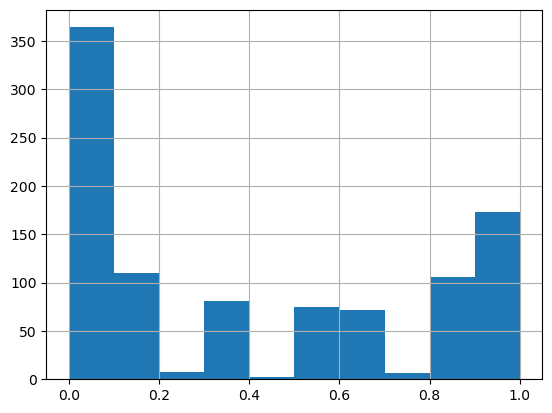

In [7]:
df['isHate'].hist()

In [8]:
# df['isHate'] = df['isHate'].apply(lambda x: 1 if x > 0.5 else 0)

In [123]:
# df.to_csv('../data/Ethos_Dataset_Binary.csv', index=False, sep=';')

In [9]:
df['isHate'].value_counts()

0    639
1    359
Name: isHate, dtype: int64

# Train,val,test split

In [ ]:
train, test = train_test_split(df,train_size=0.7,random_state=42, stratify=df['isHate'])

In [ ]:
val, test = train_test_split(test,train_size=0.5,random_state=42, stratify=test['isHate'])

# Feature extraction

In [19]:
word_vect = TfidfVectorizer(
            sublinear_tf=True,
            strip_accents='unicode',
            analyzer='word',
            stop_words='english',
            ngram_range=(1, 2),
            max_features=2000)

In [20]:
word_vect.fit(df['comment'])
train_word_features  = word_vect.transform(train['comment'])
val_word_features = word_vect.transform(val['comment'])
test_word_features  = word_vect.transform(test['comment'])

In [25]:
X_train = train_word_features.tocsr()
X_val = val_word_features.tocsr()
X_test = test_word_features.tocsr()
y_train = train['isHate']
y_val = val['isHate']
y_test = test['isHate']

In [22]:
X_train.shape, X_val.shape, X_test.shape

((698, 2000), (150, 2000), (150, 2000))

# Model creation and evaluation

In [26]:
model = cb.CatBoostClassifier()

In [27]:
model.fit(X_train, y_train)

Learning rate set to 0.008836
0:	learn: 0.6922651	total: 169ms	remaining: 2m 49s
1:	learn: 0.6914060	total: 177ms	remaining: 1m 28s
2:	learn: 0.6906400	total: 183ms	remaining: 1m
3:	learn: 0.6898139	total: 188ms	remaining: 46.9s
4:	learn: 0.6888821	total: 194ms	remaining: 38.6s
5:	learn: 0.6877980	total: 202ms	remaining: 33.4s
6:	learn: 0.6868806	total: 210ms	remaining: 29.7s
7:	learn: 0.6861590	total: 218ms	remaining: 27s
8:	learn: 0.6850364	total: 224ms	remaining: 24.7s
9:	learn: 0.6843415	total: 232ms	remaining: 22.9s
10:	learn: 0.6832256	total: 237ms	remaining: 21.3s
11:	learn: 0.6826212	total: 244ms	remaining: 20.1s
12:	learn: 0.6816600	total: 252ms	remaining: 19.1s
13:	learn: 0.6810462	total: 259ms	remaining: 18.2s
14:	learn: 0.6800669	total: 265ms	remaining: 17.4s
15:	learn: 0.6791092	total: 272ms	remaining: 16.8s
16:	learn: 0.6781526	total: 280ms	remaining: 16.2s
17:	learn: 0.6771178	total: 287ms	remaining: 15.7s
18:	learn: 0.6763113	total: 296ms	remaining: 15.3s
19:	learn: 0.6

In [113]:
train_prob = model.predict_proba(X_train)
test_prob = model.predict_proba(X_test)
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

In [29]:
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.67      0.89      0.77        96
           1       0.54      0.24      0.33        54

    accuracy                           0.65       150
   macro avg       0.61      0.56      0.55       150
weighted avg       0.63      0.65      0.61       150



In [114]:
train_metrics = {"precision_macro": precision_score(y_train, train_pred, average='macro'),
                 "recall_macro": recall_score(y_train, train_pred, average='macro'),
                 "f1_macro": f1_score(y_train, train_pred, average='macro'),
                 "roc_auc": roc_auc_score(y_train, train_prob[:, 1])
                }

test_metrics = {"precision_macro": precision_score(y_test, test_pred, average='macro'),
                "recall_macro": recall_score(y_test, test_pred, average='macro'),
                "f1_macro": f1_score(y_test, test_pred, average='macro'),
                "roc_auc": roc_auc_score(y_test, test_prob[:, 1])
                }

In [115]:
metrics_before_tuning = pd.DataFrame([train_metrics, test_metrics], index=['train', 'test']).T
metrics_before_tuning

,train,test
precision_macro,0.869430,0.608135
recall_macro,0.750261,0.563079
f1_macro,0.770831,0.549550
roc_auc,0.958760,0.676890


# Hyperparameters optimization with Optuna

In [76]:
def objective(trial: optuna.Trial) -> float:
    train_x, valid_x, train_y, valid_y = X_train, X_val, y_train, y_val

    param = {
        "iterations":trial.suggest_int("iterations", 1000, 5000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5, log=True),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        "depth": trial.suggest_int("depth", 1, 12),
        "used_ram_limit": "4gb",
        "eval_metric": "AUC",
    }

    gbm = cb.CatBoostClassifier(**param)

    pruning_callback = CatBoostPruningCallback(trial, "AUC")
    gbm.fit(
        train_x,
        train_y,
        eval_set=[(valid_x, valid_y)],
        verbose=0,
        early_stopping_rounds=100,
        callbacks=[pruning_callback],
    )

    # evoke pruning manually.
    pruning_callback.check_pruned()

    preds = gbm.predict_proba(valid_x)
    roc_auc = roc_auc_score(valid_y, preds[:, 1])

    return roc_auc

In [77]:
study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize"
    )
study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-06-06 13:18:21,248] A new study created in memory with name: no-name-6f631a29-41ad-48ac-bc43-1c96683602d4
C:\Users\Kikikita\AppData\Local\Temp\ipykernel_22468\4104715107.py:16: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "AUC")
[I 2023-06-06 13:18:22,401] Trial 0 finished with value: 0.6985918209876543 and parameters: {'iterations': 3614, 'learning_rate': 0.36555929483263033, 'colsample_bylevel': 0.06267255787237493, 'l2_leaf_reg': 0.0021334591608688468, 'depth': 3}. Best is trial 0 with value: 0.6985918209876543.
C:\Users\Kikikita\AppData\Local\Temp\ipykernel_22468\4104715107.py:16: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "AUC")
[I 2023-06-06 13:18:34,745] Trial 1 finished with value: 0.7254050925925926 and pa

Number of finished trials: 100
Best trial:
  Value: 0.765721450617284
  Params: 
    iterations: 3047
    learning_rate: 0.05098946604582998
    colsample_bylevel: 0.0946842251419649
    l2_leaf_reg: 5.302191174736766e-06
    depth: 7


In [78]:
study.best_trial.params

{'iterations': 3047,
 'learning_rate': 0.05098946604582998,
 'colsample_bylevel': 0.0946842251419649,
 'l2_leaf_reg': 5.302191174736766e-06,
 'depth': 7}

# Tuned model evaluation

In [79]:
best_model = cb.CatBoostClassifier(**study.best_trial.params, random_state=42)

In [80]:
best_model.fit(X_train, y_train)

0:	learn: 0.6851654	total: 8.94ms	remaining: 27.2s
1:	learn: 0.6784922	total: 18.2ms	remaining: 27.8s
2:	learn: 0.6684536	total: 26.3ms	remaining: 26.7s
3:	learn: 0.6640372	total: 35.5ms	remaining: 27s
4:	learn: 0.6569858	total: 45.6ms	remaining: 27.7s
5:	learn: 0.6520460	total: 53.1ms	remaining: 26.9s
6:	learn: 0.6483831	total: 59.6ms	remaining: 25.9s
7:	learn: 0.6436769	total: 68.1ms	remaining: 25.9s
8:	learn: 0.6385357	total: 75.9ms	remaining: 25.6s
9:	learn: 0.6354855	total: 90.6ms	remaining: 27.5s
10:	learn: 0.6308347	total: 99.6ms	remaining: 27.5s
11:	learn: 0.6268843	total: 108ms	remaining: 27.2s
12:	learn: 0.6243384	total: 116ms	remaining: 27s
13:	learn: 0.6199519	total: 123ms	remaining: 26.6s
14:	learn: 0.6138920	total: 132ms	remaining: 26.8s
15:	learn: 0.6104259	total: 141ms	remaining: 26.7s
16:	learn: 0.6072711	total: 150ms	remaining: 26.7s
17:	learn: 0.6036455	total: 158ms	remaining: 26.6s
18:	learn: 0.6003507	total: 166ms	remaining: 26.4s
19:	learn: 0.5975975	total: 172ms	

In [118]:
train_prob = best_model.predict_proba(X_train)
test_prob = best_model.predict_proba(X_test)
train_pred = best_model.predict(X_train)
test_pred = best_model.predict(X_test)

In [82]:
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.68      0.81      0.74        96
           1       0.50      0.33      0.40        54

    accuracy                           0.64       150
   macro avg       0.59      0.57      0.57       150
weighted avg       0.62      0.64      0.62       150



In [119]:
train_metrics = {"precision_macro": precision_score(y_train, train_pred, average='macro'),
                 "recall_macro": recall_score(y_train, train_pred, average='macro'),
                 "f1_macro": f1_score(y_train, train_pred, average='macro'),
                 "roc_auc": roc_auc_score(y_train, train_prob[:, 1])
                }

test_metrics = {"precision_macro": precision_score(y_test, test_pred, average='macro'),
                "recall_macro": recall_score(y_test, test_pred, average='macro'),
                "f1_macro": f1_score(y_test, test_pred, average='macro'),
                "roc_auc": roc_auc_score(y_test, test_prob[:, 1])
                }

In [120]:
metrics_after_tuning = pd.DataFrame([train_metrics, test_metrics], index=['train', 'test']).T
metrics_after_tuning

,train,test
precision_macro,1.0,0.592105
recall_macro,1.0,0.572917
f1_macro,1.0,0.571429
roc_auc,1.0,0.704861


In [117]:
metrics_before_tuning

,train,test
precision_macro,0.869430,0.608135
recall_macro,0.750261,0.563079
f1_macro,0.770831,0.549550
roc_auc,0.958760,0.676890


In [121]:
metrics_after_tuning - metrics_before_tuning

,train,test
precision_macro,0.130570,-0.016030
recall_macro,0.249739,0.009838
f1_macro,0.229169,0.021879
roc_auc,0.041240,0.027971
